In [2]:
!rm -rf LLM-Based-Sentiment-Analysis
!git clone https://github.com/josedanielchg/LLM-Based-Sentiment-Analysis.git
%cd LLM-Based-Sentiment-Analysis
!ls

Cloning into 'LLM-Based-Sentiment-Analysis'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 154 (delta 68), reused 121 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (154/154), 4.89 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/LLM-Based-Sentiment-Analysis/LLM-Based-Sentiment-Analysis
ELEVES_Sentiment_Analysis_Using_Naive_Bayes.ipynb  Q1
outputs						   README.md
poetry.lock					   reports
pyproject.toml					   test_df_processed.csv
Q0						   train_df_processed.csv


In [ ]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from pathlib import Path

# Add the correct functions path whether the notebook runs from repo root or /Q1
cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = (cwd / "functions").resolve()
else:
    functions_dir = (cwd / "Q1" / "functions").resolve()

sys.path.insert(0, str(functions_dir))

from eval_utils import evaluate_model
from tune_pipeline import tune_pipeline

# Load the preprocessed datasets
train_df = pd.read_csv('train_df_processed.csv')
test_df = pd.read_csv('test_df_processed.csv')

# Remove any null values that may have been created during I/O
train_df = train_df.dropna(subset=['processed_text'])
test_df = test_df.dropna(subset=['processed_text'])

# Define target labels
y_train = train_df['sentiment_class']
y_test = test_df['sentiment_class']
x_train_raw = train_df['processed_text']

#vectorizer
vectorizer = CountVectorizer()

(vectorizer, model, param_grid, X_train, y_train, model_name, output_dir='outputs', refit_metric='f1_macro', use_parallel=True)
tune_pipeline


## Modeling

In [4]:
from tune_pipeline import tune_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression


### MultinomialNB 

In [5]:
param_grid_nb = {
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__min_df": [1, 2],
    "vec__max_df": [0.9, 1.0],
    'model__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Use the text column directly because the pipeline handles vectorization
nb_search = tune_pipeline(vectorizer, MultinomialNB(), param_grid_nb, 
                          train_df['processed_text'], y_train,model_name="Multinomial_NB_TF-IDF Word")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
--- Best model saved to: outputs/Multinomial_NB_TF-IDF_Word_best.joblib
--- Performance report saved to: outputs/Multinomial_NB_TF-IDF_Word_tuning_report.csv


#### Results:

Best Params: {'model__alpha': 1.0, 'vec__max_df': 0.9, 'vec__min_df': 2, 'vec__ngram_range': (1, 1)}


/content/LLM-Based-Sentiment-Analysis/LLM-Based-Sentiment-Analysis/Q1/functions/eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//TF-IDF_Word_Tuned_MultinomialNB_Full_Report.png


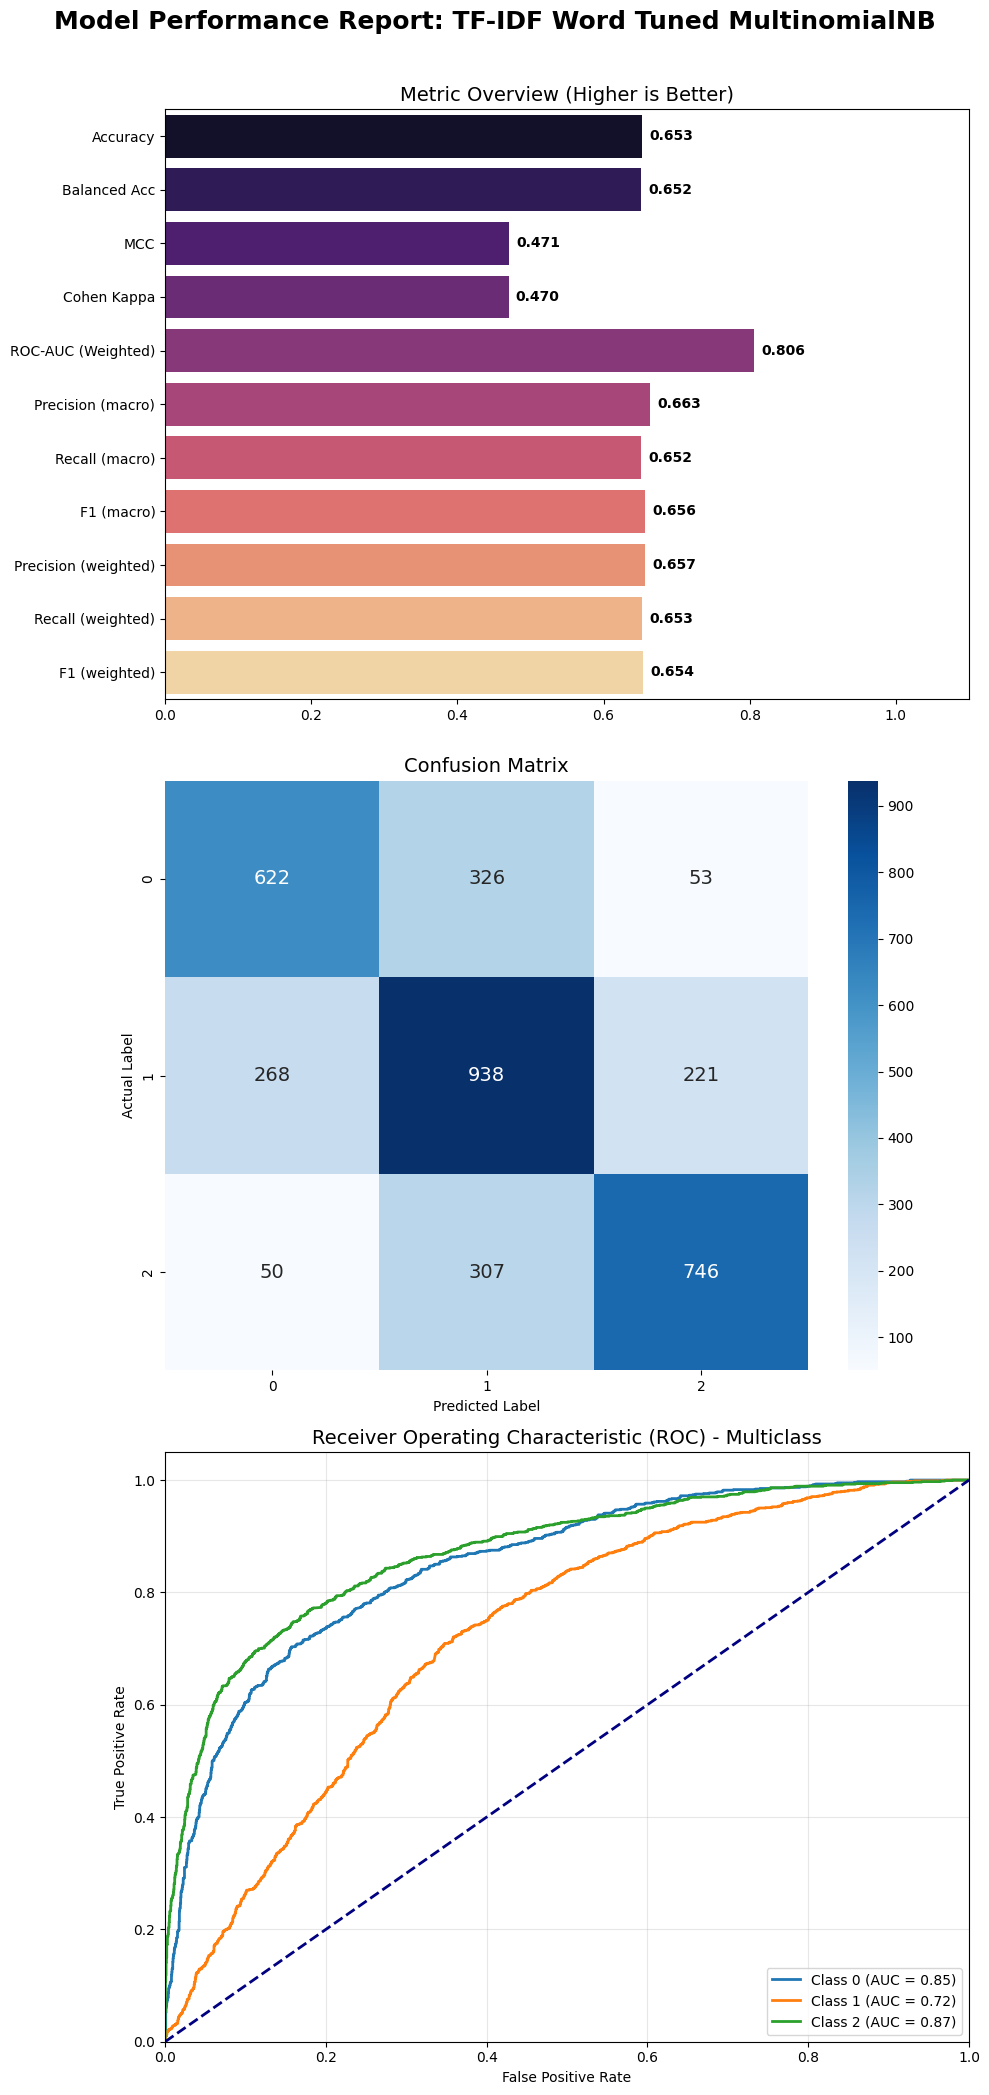

In [6]:
print(f"Best Params: {nb_search.best_params_}")
evaluate_model(
    y_test,
    nb_search.predict(test_df['processed_text']),
    nb_search.predict_proba(test_df['processed_text']),
    "TF-IDF Word Tuned MultinomialNB"
)

### Gaussian Naive Bayes

In [15]:
def to_dense(X):
    return X.toarray()

dense_vectorizer = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=1, max_df=0.9)),
    ("dense", FunctionTransformer(to_dense, accept_sparse=True))
])

param_grid_gnb = {
    "vec__tfidf__ngram_range": [(1, 1), (1, 2)],
    "vec__tfidf__min_df": [2, 5],
    "vec__tfidf__max_df": [0.9, 0.95],
    "model__var_smoothing": np.logspace(0, -9, num=5),
}

gnb_search = tune_pipeline(
    dense_vectorizer, 
    GaussianNB(), 
    param_grid_gnb, 
    x_train_raw,
    y_train,
    model_name="Gaussian_NB_TF-IDF Word",
    use_parallel=False
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
--- Best model saved to: outputs/Gaussian_NB_TF-IDF_Word_best.joblib
--- Performance report saved to: outputs/Gaussian_NB_TF-IDF_Word_tuning_report.csv


TODO: Check after, it seems GaussianNB doesnt support Vectorization input

#### Results:

Best Params: {'model__var_smoothing': np.float64(1.0), 'vec__tfidf__max_df': 0.9, 'vec__tfidf__min_df': 5, 'vec__tfidf__ngram_range': (1, 1)}


/content/LLM-Based-Sentiment-Analysis/LLM-Based-Sentiment-Analysis/Q1/functions/eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//TF-IDF_Word_Tuned_GaussianNB_Full_Report.png


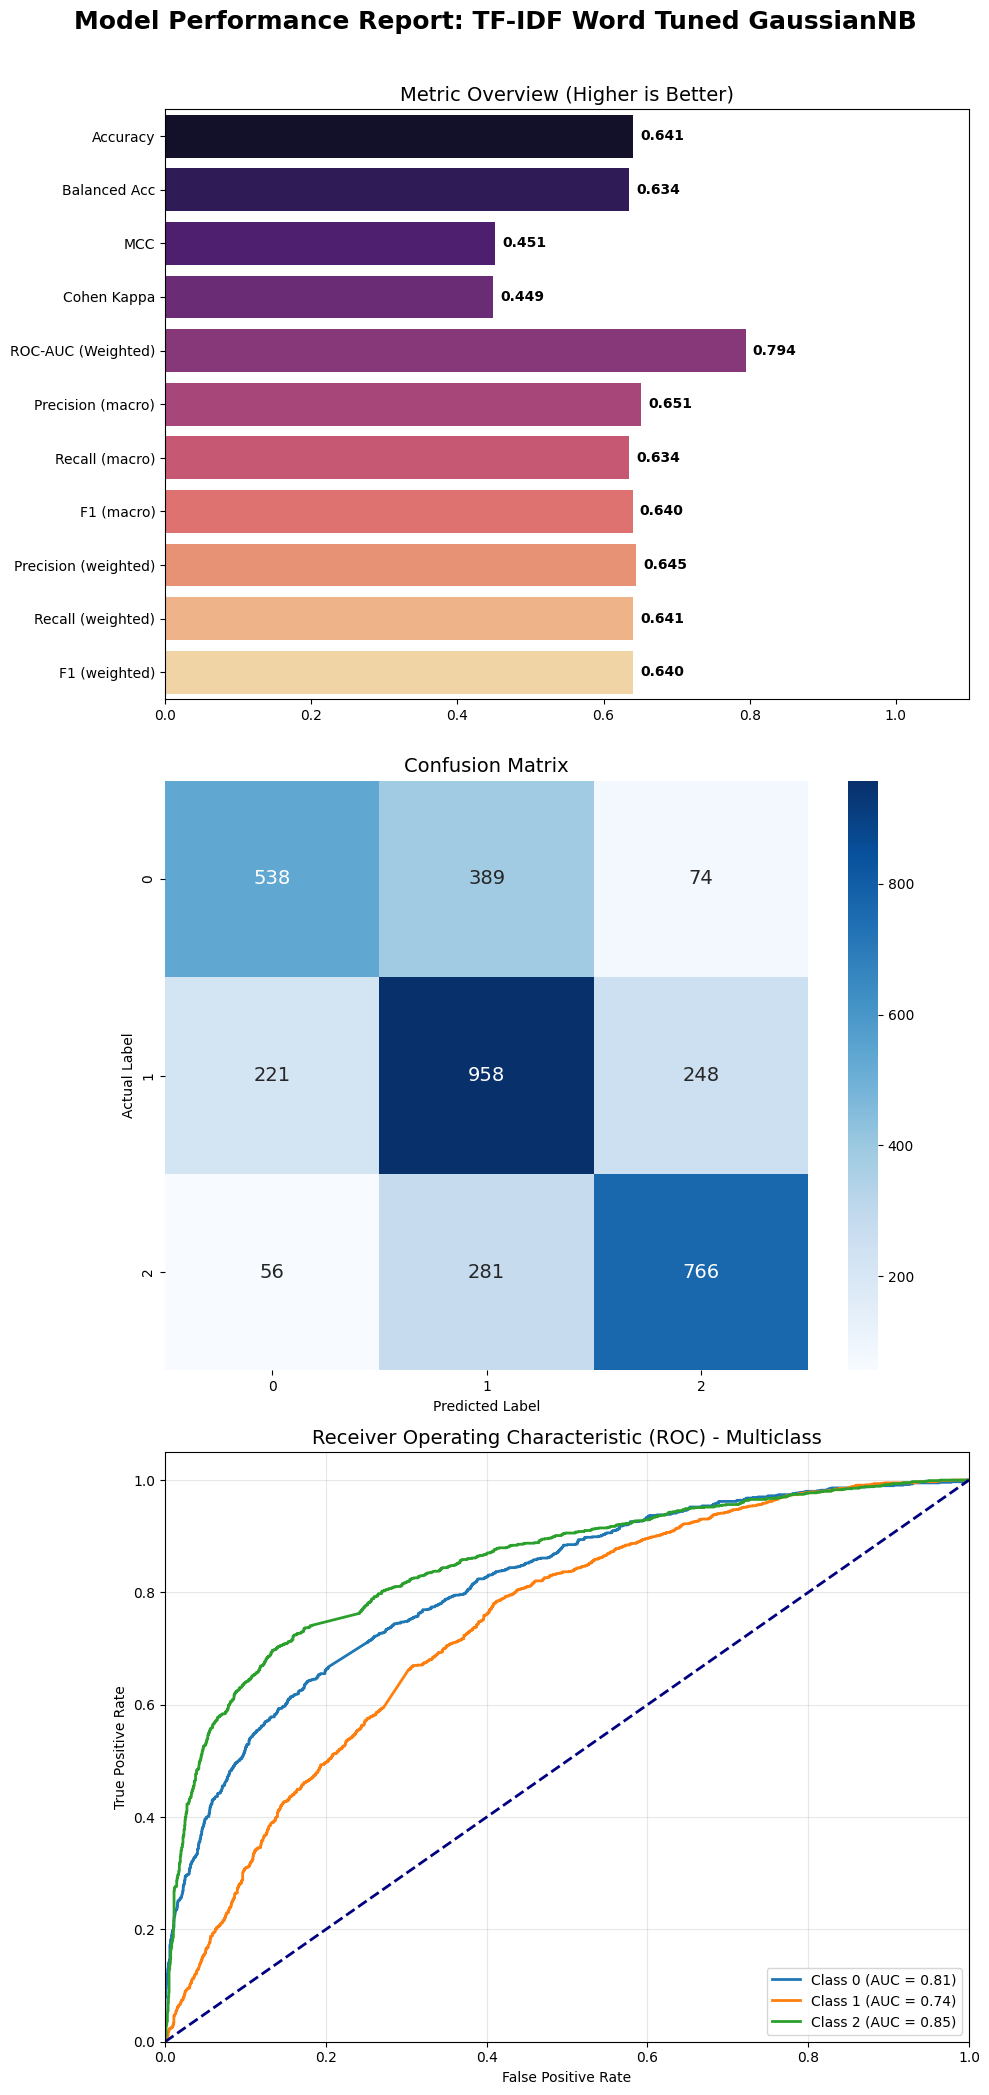

In [16]:
print(f"Best Params: {gnb_search.best_params_}")
evaluate_model(
    y_test,
    gnb_search.predict(test_df['processed_text']),
    gnb_search.predict_proba(test_df['processed_text']),
    "TF-IDF Word Tuned GaussianNB"
)

### Logistic Regression

In [ ]:
param_grid_lr = {
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__min_df": [2, 5],
    "vec__max_df": [0.9, 0.95],
    'model__C': [0.1, 1, 10],
    'model__solver': ['saga'], 
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [1000]
}

lr_search = tune_pipeline(
    vectorizer, 
    LogisticRegression(), 
    param_grid_lr, 
    x_train_raw,
    y_train,
    model_name="Logistic_Regression_TF-IDF Word",
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


#### Results:

Best Parameters: {'model__C': 1, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'saga'}
--- Results for Tuned Logistic Regression ---
Accuracy: 0.7052

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1001
           1       0.65      0.74      0.69      1427
           2       0.79      0.72      0.75      1103

    accuracy                           0.71      3531
   macro avg       0.72      0.70      0.71      3531
weighted avg       0.71      0.71      0.71      3531



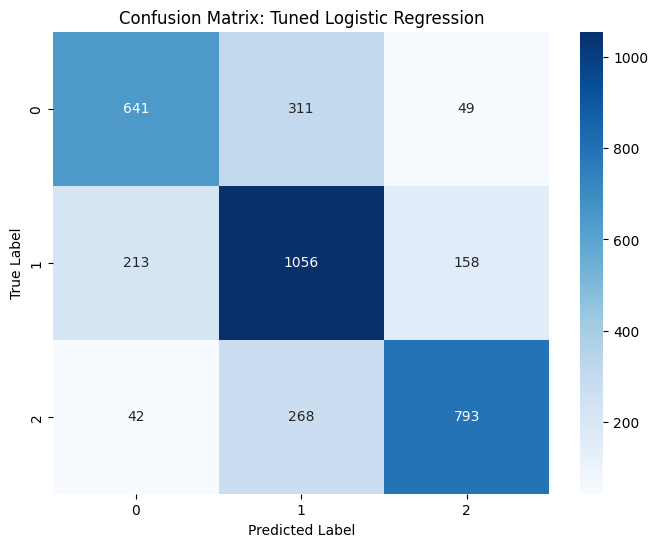

In [15]:
print(f"Best Parameters: {lr_search.best_params_}")
evaluate_model(y_test, lr_search.predict(test_df['processed_text']), "Tuned Logistic Regression")

### Linear SVM

In [13]:
param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__loss': ['squared_hinge'],
    'model__max_iter': [2000]
}
svm_search = tune_pipeline(
    vectorizer, 
    LinearSVC(), 
    param_grid_svm, 
    x_train_raw,
    y_train,
    model_name="LinearSVC_TF-IDF Word",
)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

#### Results:

Best Parameters: {'model__C': 0.1, 'model__loss': 'squared_hinge', 'model__max_iter': 2000}
--- Results for Tuned Linear SVM ---
Accuracy: 0.6975

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1001
           1       0.64      0.74      0.69      1427
           2       0.77      0.71      0.74      1103

    accuracy                           0.70      3531
   macro avg       0.71      0.69      0.70      3531
weighted avg       0.70      0.70      0.70      3531



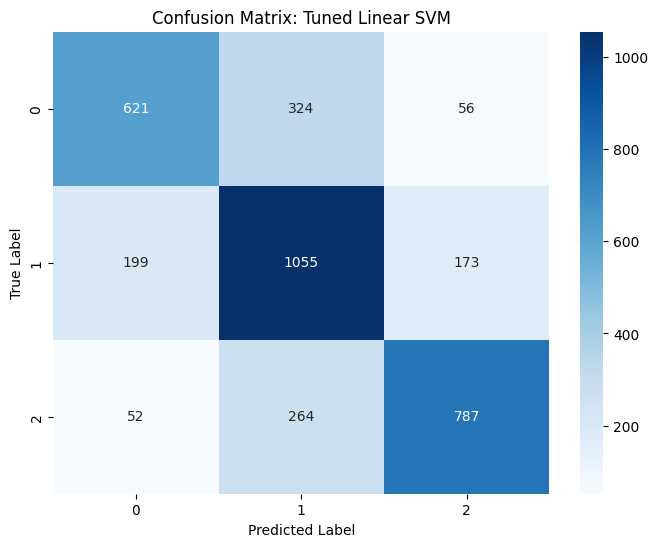

In [17]:
print(f"Best Parameters: {svm_search.best_params_}")
evaluate_model(y_test, svm_search.predict(test_df['processed_text']), "Tuned Linear SVM")

### Random Forest / Bagging / Gradient Boosting

In [14]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 20],
    'model__min_samples_split': [2, 5],
    'model__class_weight': ['balanced', None] # Useful if classes are imbalanced
}
rf_search = tune_pipeline(
    vectorizer, 
    RandomForestClassifier(n_jobs=-1), 
    param_grid_rf, 
    x_train_raw,
    y_train,
    model_name="RandomForest_TF-IDF Word",
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

#### Results:

Best Parameters: {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
--- Results for Tuned Random Forest ---
Accuracy: 0.7086

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1001
           1       0.67      0.71      0.69      1427
           2       0.77      0.76      0.76      1103

    accuracy                           0.71      3531
   macro avg       0.71      0.71      0.71      3531
weighted avg       0.71      0.71      0.71      3531



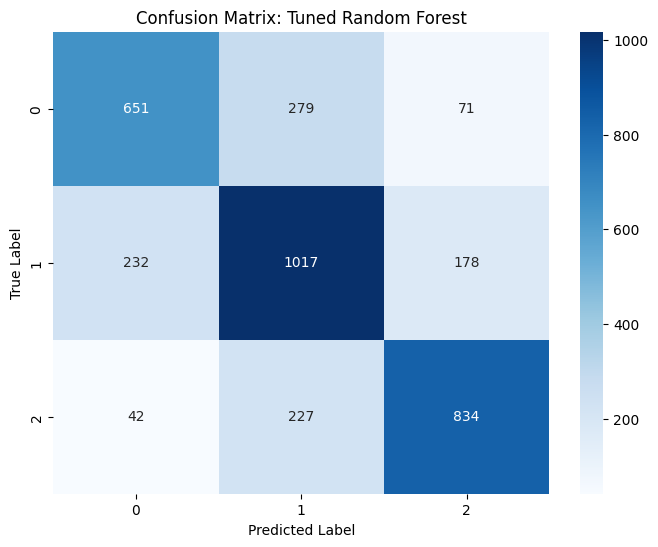

In [19]:
print(f"Best Parameters: {rf_search.best_params_}")
evaluate_model(y_test, rf_search.predict(test_df['processed_text']), "Tuned Random Forest")